In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
# dataloader arguments
batch_size = 128
data_path='./Data'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnistTrain = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnistTest = datasets.MNIST(data_path, train=False, download=True, transform=transform)
# Create DataLoaders
trainLoader = DataLoader(mnistTrain, batch_size=batch_size, shuffle=True, drop_last=True)
testLoader = DataLoader(mnistTest, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
# Network architecture
inputSize = 28 * 28 # Each MNIST dataset image has a 28 x 28 image size
hiddenSize = 1000
outSize = 10 # 10 Digits
numSteps = 25
beta = .95


loss = nn.CrossEntropyLoss()

# Define the network
class ExampleSNN(nn.Module):
    """
    Our very first implementation of a spiking neural network
    """
    def __init__(self, *args, **kwargs):
        # Inherit necessary variables from nn.Module
        super().__init__()
        
        # Make the layers
        self.layer1 = nn.Linear(inputSize, hiddenSize)
        self.LIF1 = snn.Leaky(beta = beta)
        self.layer2 = nn.Linear(hiddenSize, outSize)
        self.LIF2 = snn.Leaky(beta = beta)
    
    def forward(self, x, y):
        """
        The forward pass of the network. This part is important because we impose
        spiking behavior of neurons in it.
        
        Args:
            x: each layer's output.
        """
        # Set initial potentials to be zero
        potential1 = self.LIF1.reset_mem()
        potential2 = self.LIF2.reset_mem()
        
        # Save the state of the output layer
        layer2Spikes = []
        layer2Potentials = []
        lossRecords = []
        _loss = torch.zeros((1), dtype = torch.float32)
        
        for step in range(numSteps):
            current1 = self.layer1(x)
            spk1, potential1 = self.LIF1(current1, potential1)
            current2 = self.layer2(spk1)
            spk2, potential2 = self.LIF2(current2, potential2)
            
            # Save output
            layer2Spikes.append(spk2)
            layer2Potentials.append(potential2)
        
        # Calculate the loss
        loss_val = 0
        for step in range(numSteps):
            loss_val += loss(layer2Potentials[step], y)
            
        return torch.stack(layer2Spikes, dim = 0), torch.stack(layer2Potentials, dim = 0), loss_val


In [7]:

net = ExampleSNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

# The training loop
numEpochs = 1
lstLoss = []
lstTestLoss = []
counter = 0
_lossVal = torch.zeros((1), dtype = torch.float32, device = device)

for epoch in range(numEpochs):
    print(f"Epoch number {epoch+1}/{numEpochs}")
    
    trainBatch = iter(trainLoader)
    
    for data, target in trainBatch:
        
        data = data.to(device)
        target = target.to(device)
        
        # Set the model to training mode
        net.train()
        
        # Flatten each batch data and feed it to network
        _spk, _pot, _loss = net(data.reshape(batch_size, -1), target)
        # # _lossVal = torch.sum(_loss)
        # loss_val = torch.zeros((1), dtype=dtype, device=device)
        # for step in range(numSteps):
        #     loss_val += loss(_pot[step], target)
        
        # Update the weights
        optimizer.zero_grad() # Set previous gradients to zero
        _loss.backward()
        optimizer.step()
        
        lstLoss.append(_loss.item())
        
        # Test data
        with torch.no_grad():
            # Set the network in evaluation mode
            net.eval()
            
            testData, testTarget = next(iter(trainLoader))
            testData = testData.to(device)
            testTarget = testTarget.to(device)
            
            # Feed the test to current trained network
            _spkTest, _potTest, _testLoss = net(testData.view(batch_size, -1), testTarget)
            
            _testLoss = torch.zeros((1), dtype=dtype, device=device)
            # # Test loss
            # for step in range(numSteps):
            #     _testLoss += loss(_potTest[step], target)
            lstTestLoss.append(_testLoss.item())
            
        
        

Epoch number 1/1


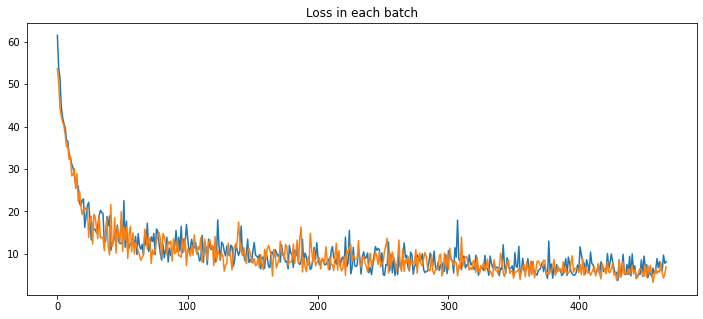

In [ ]:
fig = plt.figure(facecolor="w", figsize=(12, 5))
plt.title("Loss in each batch")
plt.plot(lstLoss)
plt.plot(lstTestLoss)
plt.show()